# LSTM IMDB Movie Review Tutorial
Josiah Olson

In [2]:
from __future__ import print_function
import time
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, BatchNormalization
from keras.datasets import imdb

import os
from keras.preprocessing.text import Tokenizer

In [3]:
max_features = 10000
max_len = 200  # cut texts after this number of words (among top max_features most common words)

In [4]:
# get dataset and unzip: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

X_train = []
y_train = []

path = './aclImdb/train/pos/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([1 for _ in range(12500)])

path = './aclImdb/train/neg/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([0 for _ in range(12500)])

print('x:')
print(X_train[:1])
print(X_train[-1:])
print(len(X_train))
print('y:')
print(y_train[:1])
print(y_train[-1:])
print(len(y_train))

x:
["Peter Ustinov plays an embezzler who is just getting out of prison when the film begins. As soon as he walks out the gates, he immediately begins working on a scheme to once again make a bundle by stealing, though this time he has his sights set pretty high. This is actually one of the weak points about the film, as he apparently knows nothing about computers (few did back in 1968) but manages to become a computer genius literally overnight! Yeah, right. Anyway, he comes up with a scheme to impersonate a computer expert and obtain a job with a large American corporation so he can eventually embezzle a ton of cash. Considering his knowledge of computers is rudimentary, it's amazing how he puts into effect a brilliant plan AND manages to infiltrate the computer system and its defenses. But, it's a movie after all, so I was able to suspend disbelief. By the end of the film, he and his new wife (Maggie Smith) are able to run away with a million pounds.<br /><br />At the very end, thou

In [5]:
# read in the test data

X_test = []
y_test = []

path = './aclImdb/test/pos/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([1 for _ in range(12500)])

path = './aclImdb/test/neg/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([0 for _ in range(12500)])

print('x:')
print(X_test[:1])
print(X_test[-1:])
print(len(X_test))
print('y:')
print(y_test[:1])
print(y_test[-1:])
print(len(y_test))

x:
["This is most likely the best picture not many will see. It presented a culture in a real unhollywoodized way. A must see for all who like Indie and for those who don't. I think this movie will draw more into the Indie scene. The acting was top notch! The character of Alice was portreyed so well. With perfect akwardness. This movie ahould be brought to the mainstream! I think it would do phenominally! ALICE is the most real look at an element of our culture that I have seen since GO ASK ALICE. A look that is untouched by the Hollywood hand. Movies like this show young people that these things aren't glamorous but that they are real and compelling. If you liked PIECES OF APRIL you will love this one!"]
['During production, this LWT series was titled \'Rocket To The Moon\', a title that everyone on set at the time thought was cheesy enough. Then word came through that it had been retitled \'Reach for the Moon\', as if this the addition of this new word would evoke heavy metaphorical 

In [6]:
#tokenize works to list of integers where each integer is a key to a word
imdbTokenizer = Tokenizer(nb_words=max_features)

imdbTokenizer.fit_on_texts(X_train)

In [7]:
#print top 20 words 
#note zero is reserved for non frequent words
for word, value in imdbTokenizer.word_index.items():
    if value < 20:
        print(value, word)

2 and
13 was
18 but
5 to
9 it
10 i
17 movie
4 of
15 for
6 is
12 that
7 br
8 in
19 film
1 the
14 as
3 a
11 this
16 with


In [8]:
#create int to word dictionary
intToWord = {}
for word, value in imdbTokenizer.word_index.items():
    intToWord[value] = word

#add a symbol for null placeholder
intToWord[0] = "!!!NA!!!"
    
print(intToWord[1])
print(intToWord[2])
print(intToWord[32])

the
and
an


In [9]:
#convert word strings to integer sequence lists
print(X_train[0])
print(imdbTokenizer.texts_to_sequences(X_train[:1]))
for value in imdbTokenizer.texts_to_sequences(X_train[:1])[0]:
    print(intToWord[value])
    
X_train = imdbTokenizer.texts_to_sequences(X_train)
X_test = imdbTokenizer.texts_to_sequences(X_test)

Peter Ustinov plays an embezzler who is just getting out of prison when the film begins. As soon as he walks out the gates, he immediately begins working on a scheme to once again make a bundle by stealing, though this time he has his sights set pretty high. This is actually one of the weak points about the film, as he apparently knows nothing about computers (few did back in 1968) but manages to become a computer genius literally overnight! Yeah, right. Anyway, he comes up with a scheme to impersonate a computer expert and obtain a job with a large American corporation so he can eventually embezzle a ton of cash. Considering his knowledge of computers is rudimentary, it's amazing how he puts into effect a brilliant plan AND manages to infiltrate the computer system and its defenses. But, it's a movie after all, so I was able to suspend disbelief. By the end of the film, he and his new wife (Maggie Smith) are able to run away with a million pounds.<br /><br />At the very end, though, i

In [12]:
# Censor the data by having a max review length (in number of words)

#use this function to load data from keras pickle instead of munging as shown above
#(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features,
#                                                      test_split=0.2)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 200)
X_test shape: (25000, 200)


In [13]:
#example of a sentence sequence, note that lower integers are words that occur more commonly
print("x:", X_train[0]) #per observation vector of 20000 words
print("y:", y_train[0]) #positive or negative review encoding

x: [ 526 1341    2 1025    5    1 1219 1507    2   91   18   42    3   17  100
   29   35   10   13  499    5 4985 2781   31    1  127    4    1   19   26
    2   24  159  319 4142 1256   23  499    5  518  242   16    3 1428 5679
    7    7   30    1   52  127  148    9  211   52   52 1496    2 1256  438
 1316    5  162   50   71  104 1428   31    8    1 5121   12 5304  643  148
   56  158  920   33   68   29 5121   11  141  381   12  847  131   56 1244
   68 3557   48   33  303    5 8966    2   10   97   27 3104  352  130    6
   12 5304    2   24  159 5824  942    8    1  156   11  874  570    2    1
   59 7606   92  410 3557  342   93    1   19  183    5 1204   20    3 2537
  274   54   28    6 1486    2  313    6  651    2   11   40  158   94   73
  278   42    3  899   63   14    1  113    2   88    4    1  484   13   84
 5278 8385 2051  823 5304    2 4142 1256   68   40  386    7    7   45   10
  303    5   25 9852    1  127  384   69  121   14    1   19  465   52 3479
    8 137

In [14]:
# double check that word sequences behave/final dimensions are as expected
print("y distribution:", np.unique(y_train, return_counts=True))
print("max x word:", np.max(X_train), "; min x word", np.min(X_train))
print("y distribution test:", np.unique(y_test, return_counts=True))
print("max x word test:", np.max(X_test), "; min x word", np.min(X_test))

y distribution: (array([0, 1]), array([12500, 12500]))
max x word: 9999 ; min x word 0
y distribution test: (array([0, 1]), array([12500, 12500]))
max x word test: 9999 ; min x word 0


In [15]:
print("most and least popular words: ")
print(np.unique(X_train, return_counts=True))
# as expected zero is the highly used word for words not in index

most and least popular words: 
(array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int32), array([1084248,  232308,  115674, ...,      23,      20,      22]))


What is an LSTM neural network?

A Long Term Short Term Memory Network is a type of Recurrent Neural Network. RNN's have multiple time steps with a feature vecture input at each time step and the prior layer's output/hidden state as an input vector. RNN's come in many varieties, for example, an RNN can take one input and predict multiple outputs, multiple inputs and multiple outputs, multiple inputs to a single output dimension, ext.

<img src="rnntypes.jpeg">
[source: Karpathy: The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

A more specific RNN where one-hot vector of English characters is the input and at character space in the text an input is provided and an output is generated for the predicted next character in the text.

<img src="charseq.jpeg">

So, how is an RNN different from an LSTM? A normal RNN has the prior output concatenated with the current input to form the feature vector for the current layer. In a basic RNN structure long term dependencies (ie: the subject of a sentence) can be hard for the network to remember over many time steps. This is refered to as the vanishing/exploding gradient problem. More reading is suggested on this, but essentially the non-linearity's effect will compound over time step's causing the prior (historic) gradient to approach either zero or infinity.

We provent this problem through the LSTM architecture. LSTM's have an input gate, output gate and forget gate. As simply as possible, this gates control what the output is for the current layer, what part of the past hidden state is forgotten based on the current input, and what part of the current input should be added to the networks long term memory vector which is passed from layer to layer along with the hidden state.

<img src="lstmchain.png">
[source: Colah: Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [17]:
#set model hyper parameters
epochs = 6
embedding_neurons = 128
lstm_neurons = 64
batch_size = 32

In [18]:
# Forward Pass LSTM Network

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.2, dropout_U=0.2)(bnorm)

# dropout 
after_dp = Dropout(0.5)(forwards)
output = Dense(1, activation='sigmoid')(after_dp)

model_fdir_atom = Model(input=sequence, output=output)
# review model structure
print(model_fdir_atom.summary())

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 200)         0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)            (None, 200, 128)    1280000     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormaliz(None, 200, 128)    256         embedding_1[0][0]                
____________________________________________________________________________________________________
lstm_1 (LSTM)                      (None, 64)          49408       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [19]:
# Forward pass LSTM network

# try using different optimizers and different optimizer configs
model_fdir_atom.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_fdir_atom = model_fdir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
286s - loss: 0.5424 - acc: 0.7199 - val_loss: 0.3598 - val_acc: 0.8464
Epoch 2/6
287s - loss: 0.3132 - acc: 0.8713 - val_loss: 0.3283 - val_acc: 0.8644
Epoch 3/6
286s - loss: 0.2166 - acc: 0.9163 - val_loss: 0.3159 - val_acc: 0.8739
Epoch 4/6
286s - loss: 0.1548 - acc: 0.9433 - val_loss: 0.3610 - val_acc: 0.8717
Epoch 5/6
286s - loss: 0.1210 - acc: 0.9564 - val_loss: 0.3854 - val_acc: 0.8722
Epoch 6/6
288s - loss: 0.0950 - acc: 0.9660 - val_loss: 0.4609 - val_acc: 0.8709
avg sec per epoch: 289.7011380990346


A Bi-directional RNN is a network where the gradient is propagated both forward and backward through time. The hidden state and cell state vector is then the concatenation of the two time steps. This is useful because now the network knows about the input vectors (word embeddings) in front of and behind the current time step.

In [20]:
# Bi-directional Atom

# based on keras tutorial: https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_atom = Model(input=sequence, output=output)
# review model structure
print(model_bidir_atom.summary())

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_2 (InputLayer)               (None, 200)         0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)            (None, 200, 128)    1280000     input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormaliz(None, 200, 128)    256         embedding_2[0][0]                
____________________________________________________________________________________________________
lstm_2 (LSTM)                      (None, 64)          49408       batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [21]:
# Bi-directional Atom

# try using different optimizers and different optimizer configs
model_bidir_atom.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_atom = model_bidir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
498s - loss: 0.5829 - acc: 0.6816 - val_loss: 0.4291 - val_acc: 0.8193
Epoch 2/6
506s - loss: 0.4177 - acc: 0.8143 - val_loss: 0.3763 - val_acc: 0.8534
Epoch 3/6
500s - loss: 0.3114 - acc: 0.8712 - val_loss: 0.3811 - val_acc: 0.8625
Epoch 4/6
504s - loss: 0.2598 - acc: 0.8978 - val_loss: 0.4055 - val_acc: 0.8445
Epoch 5/6
506s - loss: 0.2151 - acc: 0.9168 - val_loss: 0.3816 - val_acc: 0.8684
Epoch 6/6
507s - loss: 0.1810 - acc: 0.9305 - val_loss: 0.3958 - val_acc: 0.8664
avg sec per epoch: 509.0115524133046


In [22]:
# run simple linear regression to compare performance

#based on grid search done by: 
#https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch08/ch08.ipynb

#the tfidf vectors capture co-occurance statistics, think of each number representing how many times 
#a word occured in a text and scaled by word frequency

tfidfTokenizer = Tokenizer(nb_words=max_features)
tfidfTokenizer.fit_on_sequences(X_train.tolist())
X_train_tfidf = np.asarray(tfidfTokenizer.sequences_to_matrix(X_train.tolist(), mode="tfidf"))
X_test_tfidf = np.asarray(tfidfTokenizer.sequences_to_matrix(X_test.tolist(), mode="tfidf"))

In [23]:
#check tfidf matrix
print(X_train_tfidf)
print(X_train_tfidf.shape, X_test_tfidf.shape)

[[ 0.         -1.6183748  -1.73087555 ...,  0.          0.          0.        ]
 [ 0.         -1.71728432 -2.00060526 ...,  0.          0.          0.        ]
 [ 0.         -1.77371565 -2.33456537 ...,  0.          0.          0.        ]
 ..., 
 [-0.62228544 -1.83609759 -2.20140072 ...,  0.          0.          0.        ]
 [-0.30308935 -2.31623382 -3.1618598  ...,  0.          0.          0.        ]
 [-0.78452538 -2.07616571 -2.09259727 ...,  0.          0.          0.        ]]
(25000, 10000) (25000, 10000)


In [24]:
from sklearn.linear_model import LogisticRegression

model_tfidf_reg = LogisticRegression(random_state=0, C=0.001, penalty='l2', verbose=1)
model_tfidf_reg.fit(X_train_tfidf, y_train)

[LibLinear]

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [25]:
from sklearn.metrics import accuracy_score
#calculate test and train accuracy
print("train acc:", accuracy_score(y_test, model_tfidf_reg.predict(X_train_tfidf)))
print("test acc:", accuracy_score(y_test, model_tfidf_reg.predict(X_test_tfidf)))

train acc: 0.9176
test acc: 0.87328


What went wrong? Why does our complex neural net not do leaps and bounds better than classic information retrieval techniques? Neural networks tend to excell with lot's of data. If we had around a million movie reviews the literature suggests that the LSTM would vastly outperform the logistic regression. 

<img src="rnnvridge.png">
[source: indico passage github](https://github.com/IndicoDataSolutions/Passage/tree/master/examples)

In [26]:
# Bi-directional rmsprop

# this example illistrate's that choice of optimizer is an important hyper-parameter for RNNs
# rmsprop gives substancially better results than atom
# in the literature these two optimizers commonly do well on RNNs

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_rmsprop = Model(input=sequence, output=output)
# review model structure
print(model_bidir_rmsprop.summary())

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_3 (InputLayer)               (None, 200)         0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)            (None, 200, 128)    1280000     input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_3 (BatchNormaliz(None, 200, 128)    256         embedding_3[0][0]                
____________________________________________________________________________________________________
lstm_4 (LSTM)                      (None, 64)          49408       batchnormalization_3[0][0]       
___________________________________________________________________________________________

In [27]:
# Bi-directional rmsprop

model_bidir_rmsprop.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_rmsprop = model_bidir_rmsprop.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
523s - loss: 0.5914 - acc: 0.6716 - val_loss: 0.4526 - val_acc: 0.8062
Epoch 2/6
526s - loss: 0.3991 - acc: 0.8288 - val_loss: 0.3500 - val_acc: 0.8643
Epoch 3/6
526s - loss: 0.3101 - acc: 0.8750 - val_loss: 0.3185 - val_acc: 0.8796
Epoch 4/6
527s - loss: 0.2591 - acc: 0.8998 - val_loss: 0.3441 - val_acc: 0.8793
Epoch 5/6
517s - loss: 0.2206 - acc: 0.9159 - val_loss: 0.3362 - val_acc: 0.8776
Epoch 6/6
514s - loss: 0.1897 - acc: 0.9295 - val_loss: 0.3811 - val_acc: 0.8767
avg sec per epoch: 527.796077132225


In [28]:
#get weights from embedding layer and visualize

print(model_bidir_rmsprop.layers[1].get_config())
embmatrix = model_bidir_rmsprop.layers[1].get_weights()[0]
print(embmatrix.shape)

{'trainable': True, 'input_length': 200, 'output_dim': 128, 'W_constraint': None, 'input_dtype': 'int32', 'init': 'uniform', 'mask_zero': False, 'W_regularizer': None, 'name': 'embedding_3', 'batch_input_shape': (None, 200), 'input_dim': 10000, 'dropout': 0.0, 'activity_regularizer': None}
(10000, 128)


In [29]:
from sklearn.manifold import TSNE
topnwords = 5000
toptsne = TSNE(n_components=2, random_state=0)
tsneXY = toptsne.fit_transform(embmatrix[:topnwords, :]) 
tsneXY.shape

(5000, 2)

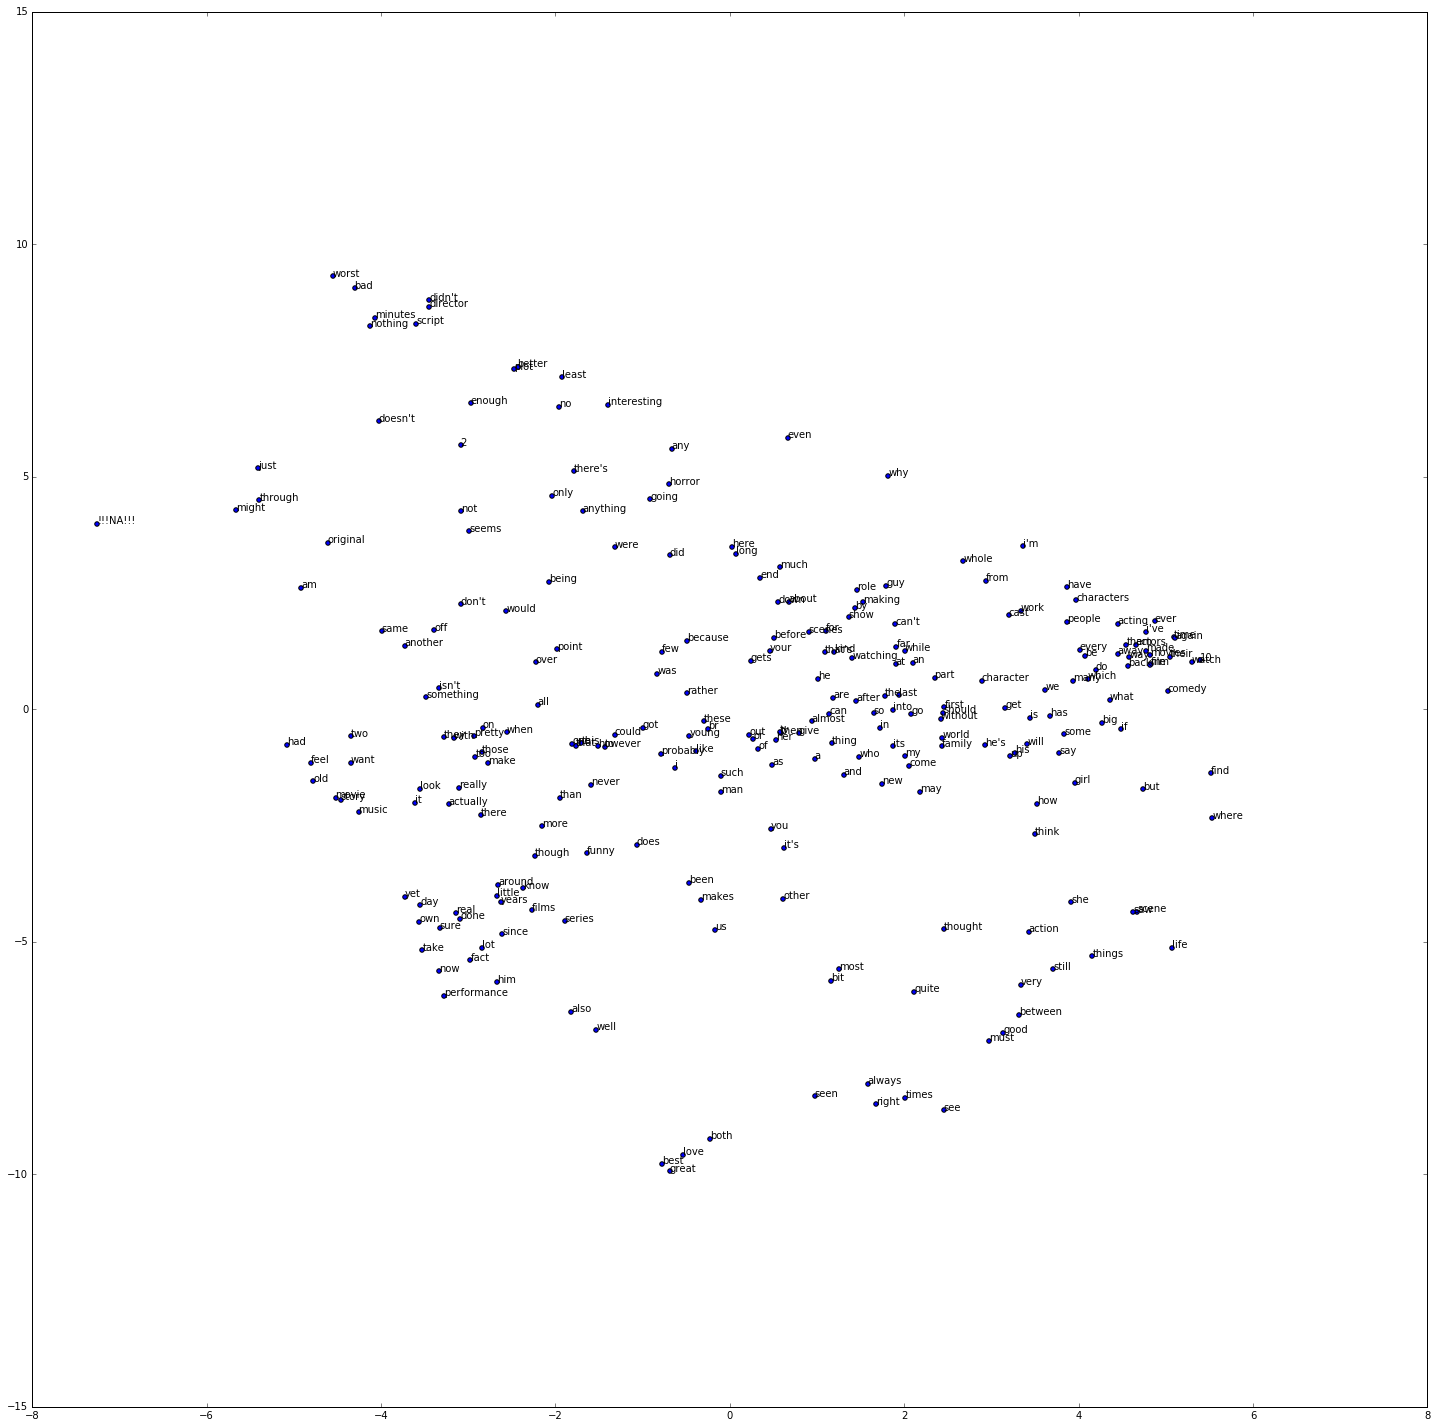

In [30]:
%matplotlib inline
displaytopnwords = 250
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(tsneXY[:displaytopnwords, 0], tsneXY[:displaytopnwords, 1])

for i in range(displaytopnwords):
    ax.annotate(intToWord[i], (tsneXY[i, 0], tsneXY[i, 1]))

fig.set_size_inches(25, 25)
plt.show()
# notice that great, most, well are clustered
# bad don't even are clustered
# We've learned structure in our sentiment embedding
# neural networks give us this and other useful features for free

Note in the image above that 'script' is close to 'bad', apparently more people use that in the negative context. Also, 'performance' is close to 'him', it appears that the embedding is learning a reference back to the pronoun.
Note, how far apart the clusters of positive and negative words are, negative words at the top of the TSNE embedding. Another cool observation, 'music' is close to 'feel', again think that aspect of this embedding is cinema specific.

In [31]:
#guide to chart above

for i in range(displaytopnwords):
    print((tsneXY[i, 0], tsneXY[i, 1], intToWord[i]))

(-7.2563256593202459, 3.9883630258994458, '!!!NA!!!')
(1.7808394964577876, 0.28420900707493096, 'the')
(1.3074923788709416, -1.413810383230826, 'and')
(0.97258376513508604, -1.0636709051629747, 'a')
(0.32762661520397507, -0.85173608614889351, 'of')
(-1.4350479582962941, -0.80866758371634495, 'to')
(3.4378501126279826, -0.18557639983027338, 'is')
(-0.24889999686753927, -0.42062066515337743, 'br')
(1.7262155260412964, -0.39519343021691189, 'in')
(-3.6097427714182357, -2.0117301664713447, 'it')
(-0.6329451082241131, -1.2518229318694318, 'i')
(-1.7021053813659366, -0.73102130031323842, 'this')
(-1.764117013490822, -0.7809036493439212, 'that')
(-0.83022767719242463, 0.7586250481093747, 'was')
(0.48896462079654518, -1.1895546496855136, 'as')
(1.0988743098147409, 1.6877591127012967, 'for')
(-3.1685738525530742, -0.62729307947154656, 'with')
(-4.5218605670113332, -1.9000801332761281, 'movie')
(4.7404464087564335, -1.7193498864520638, 'but')
(4.8252599829559752, 0.96465357738898383, 'film')
(-2

In [32]:
# Lets see what the embedding learned, 
# provoking is close to great in cosine space, that's cool and definettly movie specific

from scipy.spatial.distance import euclidean

for value in np.argsort(np.apply_along_axis(lambda x: euclidean(x, embmatrix[imdbTokenizer.word_index['great'],:]), 
                                            1, embmatrix))[:20]:
    print((intToWord[value], euclidean(embmatrix[value,:], embmatrix[imdbTokenizer.word_index['great'],:])))

('great', 0.0)
('amazing', 0.5212827324867249)
('wonderful', 0.5301917195320129)
('impressed', 0.5487397909164429)
('underrated', 0.5511659383773804)
('beauty', 0.556002676486969)
('awesome', 0.5607948899269104)
('winner', 0.561858057975769)
('holmes', 0.5652989745140076)
('ride', 0.5676301121711731)
('provoking', 0.5685350298881531)
('sweet', 0.5689787864685059)
('available', 0.568992018699646)
('balance', 0.5692850351333618)
('subtle', 0.5730404257774353)
('criminal', 0.5735073685646057)
('ironic', 0.5742459297180176)
('unforgettable', 0.5747899413108826)
('rare', 0.5760678052902222)
('impact', 0.5766984224319458)


In [33]:
from scipy.spatial.distance import cosine

for value in np.argsort(np.apply_along_axis(lambda x: cosine(x, embmatrix[imdbTokenizer.word_index['great'],:]), 
                                            1, embmatrix))[:20]:
    print((intToWord[value], cosine(embmatrix[value,:], embmatrix[imdbTokenizer.word_index['great'],:])))

('great', -7.119597689175805e-08)
('amazing', 0.32049169159623303)
('wonderful', 0.32156555138627929)
('excellent', 0.37071652504353914)
('available', 0.39210480941538683)
('impressed', 0.39659269262071206)
('today', 0.40157827429709725)
('underrated', 0.40429114808571831)
('ride', 0.40449692143994531)
('beauty', 0.41162060546385293)
('winner', 0.41534288040033673)
('awesome', 0.41715241933314673)
('heart', 0.41754174078939776)
('perfect', 0.41879362639734119)
('rare', 0.42205403276705222)
('brilliant', 0.43154722189254757)
('loved', 0.43247036209083212)
('superb', 0.43305001243310526)
('solid', 0.43443012027953165)
('sweet', 0.43829286980697058)


In [34]:
imdbTokenizer.word_index['great']

84

In [36]:
# Prep the data to do a prediction at each time step
# goal is to use this model to figure out what words cause predicted sentiment to change
# reshape to predict at every time step the review sentiment

y_train_multi = np.repeat(y_train.reshape((-1,1)), max_len, axis=1).reshape((-1,max_len,1))
y_test_multi = np.repeat(y_test.reshape((-1,1)), max_len, axis=1).reshape((-1,max_len,1))
print(y_train_multi.shape)

(25000, 200, 1)


In [37]:
# Forward Pass LSTM Network multi step predict
from keras.layers.wrappers import TimeDistributed

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.2, dropout_U=0.2, return_sequences=True)(bnorm)

# dropout 
after_dp = Dropout(0.5)(forwards)
output = TimeDistributed(Dense(1, activation='sigmoid'))(after_dp)

model_fdir_multi = Model(input=sequence, output=output)
# review model structure
print(model_fdir_multi.summary())

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_4 (InputLayer)               (None, 200)         0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)            (None, 200, 128)    1280000     input_4[0][0]                    
____________________________________________________________________________________________________
batchnormalization_4 (BatchNormaliz(None, 200, 128)    256         embedding_4[0][0]                
____________________________________________________________________________________________________
lstm_6 (LSTM)                      (None, 200, 64)     49408       batchnormalization_4[0][0]       
___________________________________________________________________________________________

In [38]:
# Forward pass LSTM network multi step predict

# try using different optimizers and different optimizer configs
model_fdir_multi.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_fdir_multi = model_fdir_multi.fit(X_train, y_train_multi,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test_multi], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
328s - loss: 0.6050 - acc: 0.6518 - val_loss: 0.5505 - val_acc: 0.7073
Epoch 2/6
335s - loss: 0.4968 - acc: 0.7335 - val_loss: 0.5090 - val_acc: 0.7258
Epoch 3/6
343s - loss: 0.4503 - acc: 0.7593 - val_loss: 0.5221 - val_acc: 0.7252
Epoch 4/6
347s - loss: 0.4181 - acc: 0.7751 - val_loss: 0.5296 - val_acc: 0.7147
Epoch 5/6
347s - loss: 0.3945 - acc: 0.7865 - val_loss: 0.5916 - val_acc: 0.7173
Epoch 6/6
341s - loss: 0.3734 - acc: 0.7963 - val_loss: 0.5870 - val_acc: 0.7184
avg sec per epoch: 343.41444504261017


In [40]:
y_test_pred_mult = model_fdir_multi.predict(X_test)
y_test_pred_mult.shape

(25000, 200, 1)

In [51]:
# as a sanity check look at the accuracy of the final prediction
accuracy_score(y_test_multi[:,-1,:].ravel(), y_test_pred_mult[:,-1,:].ravel() > 0.5)

0.86119999999999997

In [63]:
print("avg starting review:", np.median(y_test_pred_mult[:,0,:]))
print("max starting review:", np.max(y_test_pred_mult[:,0,:]))
print("min starting review:", np.min(y_test_pred_mult[:,0,:]))

avg starting review: 0.525825202465
max starting review: 0.899692058563
min starting review: 0.090793274343


In [50]:
np.mean(y_test_pred_mult[:,-1,:].ravel())

0.50146971679277719

In [64]:
for review in y_test_pred_mult[:,:,:][:10]:
    for word in review:
        print(word)

0.986877501011


In [66]:
predDelta = y_test_pred_mult[:,1:,:] - y_test_pred_mult[:,:-1,:]
predDelta.shape

(25000, 199, 1)

In [94]:
# concatenate 0.5 (neutral sentiment) to the initial dimension 
predDelta = np.concatenate((np.repeat(0.5, 25000).reshape((-1,1)), predDelta.reshape((-1, max_len-1))), axis=1)
predDelta.shape

(25000, 200)

In [102]:
# group the predDelta value by the sequence index value in X_test 
# to figure out which words cause sentiment to change the most

ascDeltaWords = [np.mean(predDelta[X_test == x]) for x in range(max_features)]

/home/thenome/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [124]:
# filter out nan for words not observed in test set
ascDeltaWords = [0 if np.isnan(x) else x for x in ascDeltaWords]

In [130]:
print("Larget positive deltas")
count = 0
for value in np.argsort(ascDeltaWords).tolist()[::-1]:
    #filter to only look at commonly used words
    if value < 1000:
        count += 1
        print((value, intToWord[value], np.mean(predDelta[X_test == value])))
        if count > 20:
            break

Larget positive deltas
(318, 'excellent', 0.1135530759048801)
(444, 'loved', 0.10824652494908857)
(477, 'amazing', 0.1053537991351865)
(774, 'fantastic', 0.096833608217064548)
(526, 'brilliant', 0.091208578346822097)
(767, 'surprised', 0.087269864032603492)
(386, 'wonderful', 0.08310811262488664)
(511, 'favorite', 0.0797732096012847)
(817, 'realistic', 0.079194901447064689)
(988, 'masterpiece', 0.075743083126526542)
(507, 'enjoyed', 0.075512382078529103)
(830, 'greatest', 0.073290431016200294)
(400, 'perfect', 0.072729911018092799)
(972, 'powerful', 0.071959564074604215)
(639, 'hilarious', 0.069466818333931368)
(115, 'best', 0.069015149195531311)
(690, '7', 0.068242754817720061)
(897, 'superb', 0.066684719748502846)
(955, 'plenty', 0.06476325929448333)
(734, 'enjoyable', 0.064571092524283752)
(706, '8', 0.062462477409835196)


In [131]:
print("Larget negative deltas")
count = 0
for value in np.argsort(ascDeltaWords).tolist():
    #filter to only look at commonly used words
    if value < 1000:
        count += 1
        print((value, intToWord[value], np.mean(predDelta[X_test == value])))
        if count > 20:
            break

Larget negative deltas
(246, 'worst', -0.15909575486241459)
(370, 'awful', -0.1244145495161994)
(858, 'poorly', -0.10577680406002503)
(469, 'unfortunately', -0.10169188567438291)
(355, 'boring', -0.098990060330637994)
(391, 'terrible', -0.097384153465498932)
(832, 'lame', -0.0892755556459114)
(335, 'poor', -0.082634137495456339)
(524, 'horrible', -0.080569665198860843)
(420, 'supposed', -0.080315845656580259)
(613, 'annoying', -0.078367447825396883)
(645, 'ridiculous', -0.077781594174762145)
(750, 'dull', -0.076871606111156426)
(944, 'mess', -0.074934110150582364)
(75, 'bad', -0.0747984467143325)
(907, 'badly', -0.074105306903817766)
(860, 'okay', -0.071693332099578164)
(375, 'stupid', -0.069879267600081313)
(430, 'worse', -0.067640220894395683)
(993, 'fails', -0.067170482558871147)
(759, 'bunch', -0.065211902330915686)


It's pretty cool that with only 25,000 training examples the network was able to learn so accurately what types of words cause a review to transition from positive to negative sentiment or vice versa. I have to image this would only improve with more data. 

Now let's concatenate the words with the highest absolute delta sentiment values and use the prior train TSNE embedding model to chart how these words are clustered on the manifold the network has learned.

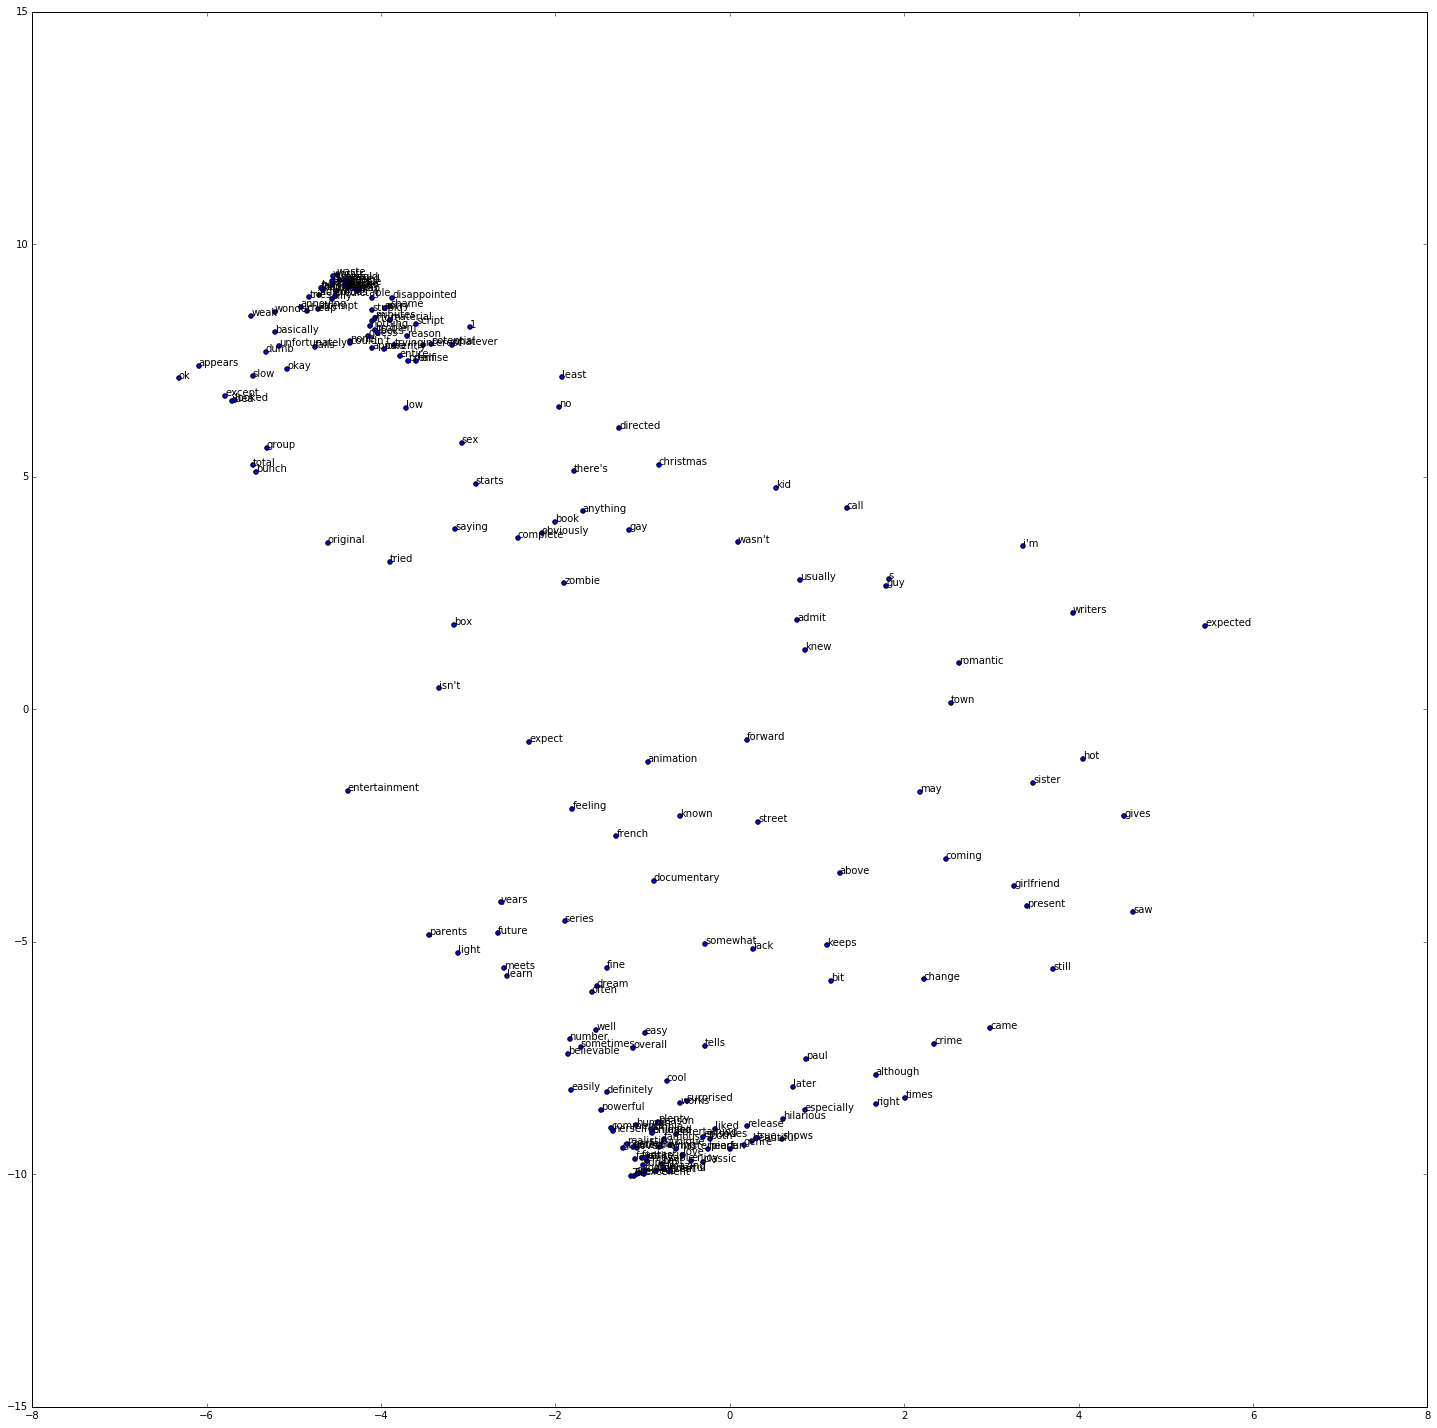

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(tsneXY[posToNegWordList, 0], tsneXY[posToNegWordList, 1])

for i in posToNegWordList:
    ax.annotate(intToWord[i], (tsneXY[i, 0], tsneXY[i, 1]))

fig.set_size_inches(25, 25)
plt.show()
# notice that we have two very distinct clusters in the embedding as one would expect

Next let's import pre-trained word vectors from google and use them to initialize our embedding to see if this improves the neural net's performance.

In [142]:
from gensim.models import Word2Vec

#get pre trained word2vec from google:
#https://doc-0k-4g-docs.googleusercontent.com/docs/securesc/gnqvgap6hjncpd3b10i2tv865io48jas/hmjtdgee48c14e1parufukrpkb8urra5/1463018400000/06848720943842814915/09676831593570546402/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&nonce=4l49745nmtine&user=09676831593570546402&hash=i2qe9mshan4mesl112ct9bu1tj9kr1hq

googlew2v = Word2Vec.load_word2vec_format('./googleword2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [155]:
# get word vectors for words in my index
googleVecs = []
for value in range(max_features):
    try:
        googleVecs.append(googlew2v[intToWord[value]])
    except:
        googleVecs.append(np.random.uniform(size=300))

googleVecs = np.array(googleVecs)

print(googleVecs)
print(googleVecs.shape)

[[ 0.01353668  0.33976858  0.279984   ...,  0.14643192  0.16220523
   0.34893078]
 [ 0.08007812  0.10498047  0.04980469 ...,  0.00366211  0.04760742
  -0.06884766]
 [ 0.46788825  0.24908416  0.07994805 ...,  0.12019843  0.88012847
   0.4712616 ]
 ..., 
 [-0.28710938 -0.109375    0.17871094 ..., -0.09228516 -0.20605469
   0.14550781]
 [-0.09082031  0.34960938  0.08154297 ...,  0.02502441 -0.24023438
   0.14160156]
 [ 0.25976562  0.13574219  0.18847656 ..., -0.28515625  0.11474609
   0.05688477]]
(10000, 300)


In [170]:
# Bi-directional google

# this example tests if using pretrained embeddings will improve performance 
# relative to starting with random embeddings

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, 300, input_length=max_len, weights=[googleVecs])(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_google = Model(input=sequence, output=output)
# review model structure
print(model_bidir_google.summary())

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_5 (InputLayer)               (None, 200)         0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)            (None, 200, 300)    3000000     input_5[0][0]                    
____________________________________________________________________________________________________
batchnormalization_5 (BatchNormaliz(None, 200, 300)    600         embedding_5[0][0]                
____________________________________________________________________________________________________
lstm_7 (LSTM)                      (None, 64)          93440       batchnormalization_5[0][0]       
___________________________________________________________________________________________

In [171]:
# Bi-directional google

model_bidir_google.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_google = model_bidir_google.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
718s - loss: 0.6614 - acc: 0.5989 - val_loss: 0.7493 - val_acc: 0.5954
Epoch 2/6
706s - loss: 0.5253 - acc: 0.7433 - val_loss: 0.4185 - val_acc: 0.8175
Epoch 3/6
685s - loss: 0.4361 - acc: 0.8084 - val_loss: 0.3547 - val_acc: 0.8581
Epoch 4/6
686s - loss: 0.3751 - acc: 0.8422 - val_loss: 0.3008 - val_acc: 0.8770
Epoch 5/6
678s - loss: 0.3290 - acc: 0.8668 - val_loss: 0.3027 - val_acc: 0.8825
Epoch 6/6
686s - loss: 0.3011 - acc: 0.8800 - val_loss: 0.2983 - val_acc: 0.8864
avg sec per epoch: 699.137955625852


The model with pre-trained word2vec vector's didn't outperform a random embedding, but I suspect it may have if I had run more epochs. Moreover, the number of parameters went up ~3x because the pre-trained vectors were 300d rather than 128d. I suspect I would have had better luck using the glove 6 billion vectors which are 100d instead. Our dataset is just too small to fit a 3 million weight embedding

In [184]:
test = "I would want to see this movie."

test = imdbTokenizer.texts_to_sequences([test])

from keras.preprocessing import sequence
test = sequence.pad_sequences(test, maxlen=max_len)

test

model_bidir_rmsprop.predict(test)

array([[ 0.38526863]])